In [ ]:
import sys, os
if os.path.abspath(os.pardir) not in sys.path:
    sys.path.insert(1, os.path.abspath(os.pardir))
import CONFIG

%reload_ext autoreload
%autoreload 2

In [ ]:
from IPython.display import Image

import pandas as pd
import numpy as np
import cv2
import os, re
import random

import torch

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [ ]:
DATA_DIR = CONFIG.CFG.DATA.BASE
MODELS_OUT_DIR = CONFIG.CFG.DATA.MODELS_OUT
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ON_CPU = DEVICE == torch.device('cpu')
TRAIN_BATCH_SIZE = 4 if ON_CPU else 6
VALID_BATCH_SIZE = 2 if ON_CPU else 2
NUM_EPOCHS = 5 if ON_CPU else 7
NEW_COLUMNS = ['x', 'y', 'w', 'h']

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))

UNIQ_TRAIN_IMAGE_IDS = train_df["image_id"].unique()

train_df.shape, test_df.shape

In [ ]:
# expand the bbox coordinates into x, y, w, h
def expand_bbox(x):
    # also convert everything to np.float
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x), dtype=np.float)
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

# initialize new columns with -1
for new_column in NEW_COLUMNS:
    train_df[new_column] = -1

train_df[NEW_COLUMNS] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    assert image is not None, f"IMAGE NOT FOUND AT {image_path}"
    return image

In [ ]:
def draw_bboxes(boxes, image, color=(255,0,0)):
    for box in boxes:
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 3
        )
    return image

In [ ]:
def plot_random_train_sample():
    image_id = np.random.choice(UNIQ_TRAIN_IMAGE_IDS)
    plt.title(image_id)
    image = load_image(os.path.join(DATA_DIR, "train", f"{image_id}.jpg"))
    bboxes = (train_df[train_df["image_id"] == image_id][NEW_COLUMNS]).to_numpy()
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    plt.imshow(draw_bboxes(bboxes, image))

In [ ]:
# plot_random_train_sample()

In [38]:
class WheatDataset(Dataset):
    def __init__(self, df, image_dir, transforms=None, test=False):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.test = test
        self.image_ids = df['image_id'].unique()

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        p_ratio = random.random()
        
        if self.test or p_ratio > 0.6:
            image, boxes = self.load_image_and_boxes(index)
        else:
            if p_ratio < 0.2:
                image, boxes = self.load_mosaic_image_and_boxes(index)
            elif p_ratio < 0.4:
                image, boxes = self.load_image_and_bboxes_with_cutmix(index)
            else:
                image, boxes = self.load_mixup_image_and_boxes(index)
        
        # change the shape from [h,w,c] to [c,h,w]  
        # image = torch.from_numpy(image).permute(2,0,1)

        # change the co-ordinates into expected [x, y, x+w, y+h] format
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # since all the boxes are wheat, it's all 1s
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([index])

        if self.transforms:
            aug = self.transforms(image=image, bboxes=boxes, labels=labels)
            while len(aug['bboxes']) != labels.shape[0]:
                aug = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = aug['image']
            target['boxes'] = torch.as_tensor(aug['bboxes'], dtype=torch.float)
            target['labels'] = torch.as_tensor(aug['labels'], dtype=torch.int64)

        return image, target

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = load_image(os.path.join(self.image_dir, f"{image_id}.jpg")).astype(np.float32)
        image /= 255.0
        records = self.df[self.df['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_mosaic_image_and_boxes(self, index, imsize=1024):
        """
        This implementation of mosaic author:  https://www.kaggle.com/nvnnghia
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[
            np.where((result_boxes[:, 2] - result_boxes[:, 0]) * (result_boxes[:, 3] - result_boxes[:, 1]) > 0)]
        return result_image, result_boxes

    def load_image_and_bboxes_with_cutmix(self, index):
        image, bboxes = self.load_image_and_boxes(index)
        image_to_be_mixed, bboxes_to_be_mixed = self.load_image_and_boxes(
            random.randint(0, self.image_ids.shape[0] - 1))

        image_size = image.shape[0]
        cutoff_x1, cutoff_y1 = [int(random.uniform(image_size * 0.0, image_size * 0.49)) for _ in range(2)]
        cutoff_x2, cutoff_y2 = [int(random.uniform(image_size * 0.5, image_size * 1.0)) for _ in range(2)]

        image_cutmix = image.copy()
        image_cutmix[cutoff_y1:cutoff_y2, cutoff_x1:cutoff_x2] = image_to_be_mixed[cutoff_y1:cutoff_y2,
                                                                 cutoff_x1:cutoff_x2]

        # Begin preparing bboxes_cutmix.
        # Case 1. Bounding boxes not intersect with cut off patch.
        bboxes_not_intersect = bboxes[np.concatenate((np.where(bboxes[:, 0] > cutoff_x2),
                                                      np.where(bboxes[:, 2] < cutoff_x1),
                                                      np.where(bboxes[:, 1] > cutoff_y2),
                                                      np.where(bboxes[:, 3] < cutoff_y1)), axis=None)]

        # Case 2. Bounding boxes intersect with cut off patch.
        bboxes_intersect = bboxes.copy()

        top_intersect = np.where((bboxes[:, 0] < cutoff_x2) &
                                 (bboxes[:, 2] > cutoff_x1) &
                                 (bboxes[:, 1] < cutoff_y2) &
                                 (bboxes[:, 3] > cutoff_y2))
        right_intersect = np.where((bboxes[:, 0] < cutoff_x2) &
                                   (bboxes[:, 2] > cutoff_x2) &
                                   (bboxes[:, 1] < cutoff_y2) &
                                   (bboxes[:, 3] > cutoff_y1))
        bottom_intersect = np.where((bboxes[:, 0] < cutoff_x2) &
                                    (bboxes[:, 2] > cutoff_x1) &
                                    (bboxes[:, 1] < cutoff_y1) &
                                    (bboxes[:, 3] > cutoff_y1))
        left_intersect = np.where((bboxes[:, 0] < cutoff_x1) &
                                  (bboxes[:, 2] > cutoff_x1) &
                                  (bboxes[:, 1] < cutoff_y2) &
                                  (bboxes[:, 3] > cutoff_y1))

        # Remove redundant indices. e.g. a bbox which intersects in both right and top.
        right_intersect = np.setdiff1d(right_intersect, top_intersect)
        right_intersect = np.setdiff1d(right_intersect, bottom_intersect)
        right_intersect = np.setdiff1d(right_intersect, left_intersect)
        bottom_intersect = np.setdiff1d(bottom_intersect, top_intersect)
        bottom_intersect = np.setdiff1d(bottom_intersect, left_intersect)
        left_intersect = np.setdiff1d(left_intersect, top_intersect)

        bboxes_intersect[:, 1][top_intersect] = cutoff_y2
        bboxes_intersect[:, 0][right_intersect] = cutoff_x2
        bboxes_intersect[:, 3][bottom_intersect] = cutoff_y1
        bboxes_intersect[:, 2][left_intersect] = cutoff_x1

        bboxes_intersect[:, 1][top_intersect] = cutoff_y2
        bboxes_intersect[:, 0][right_intersect] = cutoff_x2
        bboxes_intersect[:, 3][bottom_intersect] = cutoff_y1
        bboxes_intersect[:, 2][left_intersect] = cutoff_x1

        bboxes_intersect = bboxes_intersect[np.concatenate((top_intersect,
                                                            right_intersect,
                                                            bottom_intersect,
                                                            left_intersect), axis=None)]

        # Case 3. Bounding boxes inside cut off patch.
        bboxes_to_be_mixed[:, [0, 2]] = bboxes_to_be_mixed[:, [0, 2]].clip(min=cutoff_x1, max=cutoff_x2)
        bboxes_to_be_mixed[:, [1, 3]] = bboxes_to_be_mixed[:, [1, 3]].clip(min=cutoff_y1, max=cutoff_y2)

        # Integrate all those three cases.
        bboxes_cutmix = np.vstack((bboxes_not_intersect, bboxes_intersect, bboxes_to_be_mixed)).astype(int)
        bboxes_cutmix = bboxes_cutmix[np.where((bboxes_cutmix[:, 2] - bboxes_cutmix[:, 0]) \
                                               * (bboxes_cutmix[:, 3] - bboxes_cutmix[:, 1]) > 500)]
        # End preparing bboxes_cutmix.

        return image_cutmix, bboxes_cutmix

    def load_mixup_image_and_boxes(self, index):
        image, boxes = self.load_image_and_boxes(index)
        r_image, r_boxes = self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        return (image + r_image) / 2, np.vstack((boxes, r_boxes)).astype(np.int32)


In [ ]:
# def get_model():
#     """
#     We change the backbone to use the ResNet101 model instead, DETAILS AT:
#     https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#modifying-the-model-to-add-a-different-backbone
#     """
#     resnet_101 = torchvision.models.resnet101(pretrained=True)
#     layers = list(resnet_101.children())[:-2]
#     backbone = torch.nn.Sequential(*layers)
#     backbone.out_channels = 2048

#     anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

#     # roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#     #                                             output_size=7,
#     #                                             sampling_ratio=2)

#     # put the pieces together inside a FasterRCNN model
#     model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator)

#     return model

In [ ]:
def get_model():
    """
    https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
    """
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    model = FasterRCNN(backbone, num_classes=2)
    return model

In [26]:
# 10% into validation
n_validation = int(0.1* len(UNIQ_TRAIN_IMAGE_IDS))
valid_ids = UNIQ_TRAIN_IMAGE_IDS[-n_validation:]
train_ids = UNIQ_TRAIN_IMAGE_IDS[:-n_validation]

df_in_valid = train_df[train_df['image_id'].isin(valid_ids)]
df_in_train = train_df[train_df['image_id'].isin(train_ids)]

print("%i training samples\n%i validation samples" % (len(df_in_train["image_id"].unique()), len(df_in_valid["image_id"].unique())))

3036 training samples
337 validation samples


In [39]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [40]:
train_dataset = WheatDataset(df_in_train, os.path.join(DATA_DIR, "train"), get_train_transforms())
valid_dataset = WheatDataset(df_in_valid, os.path.join(DATA_DIR, "train"), get_valid_transforms())

# since our single getitem returns image, targets. [shape of targets is different depending on the number of bounding boxes in the image] ?
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

In [ ]:
# # check the batch is working
# batch_of_images, batch_of_targets = next(iter(train_data_loader))
# sample_boxes = batch_of_targets[0]['boxes'].cpu().numpy().astype(np.int32)
# # convert to normal image format
# sample_image = batch_of_images[0].permute(1,2,0).cpu().numpy()
# plt.imshow(draw_bboxes(sample_boxes, sample_image))

In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [23]:
model = get_model()
model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [41]:
train_losses = Averager()
val_losses = Averager()
lowest_val_loss = float('inf')

# has to be in train mode for both train and valid coz the outputs are different in two cases
model.train()
for epoch in range(NUM_EPOCHS):
    train_losses.reset()
    val_losses.reset()

    for batch_index, (images, targets) in enumerate(train_data_loader):
        # move the images and targets to device
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images,targets)
        loss = sum(loss for loss in loss_dict.values())

        # track the loss
        train_losses.send(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 50 == 0:
            print(f"Epoch: {epoch} Batch Index: {batch_index} Loss: {loss.item()}")

    # evaluate
    with torch.no_grad():
        for _, (images, targets) in enumerate(valid_data_loader):
            # move the images and targets to device
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_loss = sum(loss for loss in val_loss_dict.values())

            # track the loss
            val_losses.send(val_loss.item())

    if val_losses.value < lowest_val_loss:
        torch.save(model.state_dict(), os.path.join(MODELS_OUT_DIR, "best_model.pth"))
    else:
        if lr_scheduler is not None:
            lr_scheduler.step()
    
    # print stats
    print(f"Epoch #{epoch} TRAIN LOSS: {train_losses.value} VALIDATION LOSS: {val_losses.value}\n")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
Epoch: 0 Batch Index: 0 Loss: 2.056020736694336
Epoch: 0 Batch Index: 50 Loss: 1.7711585760116577
Epoch: 0 Batch Index: 100 Loss: 1.54567551612854
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5d6c2938d0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()


In [ ]:
torch.save(model.state_dict(), os.path.join(MODELS_OUT_DIR, 'fasterRCNN_101.pth'))

In [42]:
CONFIG.upload_to_kaggle("fasterrcnnresnet101", "Faster R-CNN ResNet-101", new=False)

In [43]:
# ####
# INFERENCE
# ####
test_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
test_df.shape

(10, 2)

In [44]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
#         # change the shape from [h,w,c] to [c,h,w]  
#         image = torch.from_numpy(image).permute(2,0,1)

        records = self.df[self.df['image_id'] == image_id]
    
        if self.transforms:
            sample = {"image": image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

In [46]:
%%capture
model.eval()

In [54]:
def get_test_transforms():
    return A.Compose([
            ToTensorV2(p=1.0),
        ], p=1.0)

In [55]:
test_dataset = WheatDataset(test_df, os.path.join(DATA_DIR, "test"), get_test_transforms())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [56]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [117]:
detection_threshold = 0.3
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [118]:
results[0]

{'PredictionString': '0.9875 73 0 96 164 0.9808 563 538 118 182 0.9795 619 923 72 95 0.9776 550 56 140 197 0.9761 702 397 108 161 0.9753 250 89 123 141 0.9535 598 783 79 108 0.9447 244 843 98 76 0.9438 464 858 73 90 0.9329 340 665 100 144 0.9324 326 868 69 86 0.9298 78 860 105 71 0.9259 743 781 71 98 0.9067 33 457 80 134 0.8900 96 617 108 74 0.8683 366 536 85 73 0.8535 824 703 88 202 0.8038 182 572 99 180 0.4902 309 1 65 60 0.4110 832 630 72 120',
 'image_id': 'aac893a91'}

In [119]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()
# test_df.to_csv("submission.csv", index=False)

image_id                                   PredictionString
0  aac893a91  0.9875 73 0 96 164 0.9808 563 538 118 182 0.97...
1  51f1be19e  0.9823 612 87 156 177 0.9389 283 471 130 125 0...
2  f5a1f0358  0.9809 891 652 79 139 0.9763 2 849 58 100 0.97...
3  796707dd7  0.9749 905 338 95 80 0.9703 1 456 64 70 0.9672...
4  51b3e36ab  0.9913 542 30 247 130 0.9886 468 25 77 131 0.9...

In [149]:
%%capture
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(30,30))

In [152]:
for j, result in enumerate(results):
    bboxes = []
    preds = result['PredictionString'].split(" ")
    for i in range(0, len(preds), 5):
        bbox_i = preds[i:i+5]
        bbox_j = bbox_i[1:]
        bbox_k = list(map(lambda x: int(x), bbox_j))
        bboxes.append(bbox_k)
    bboxes = np.array(bboxes)
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    image = load_image(os.path.join(DATA_DIR, "test", f"{result['image_id']}.jpg"))
    if j % 2 == 0:
        axes[int(j/2),0].imshow(draw_bboxes(bboxes, image))
    else:
        axes[int(j/2),1].imshow(draw_bboxes(bboxes, image))

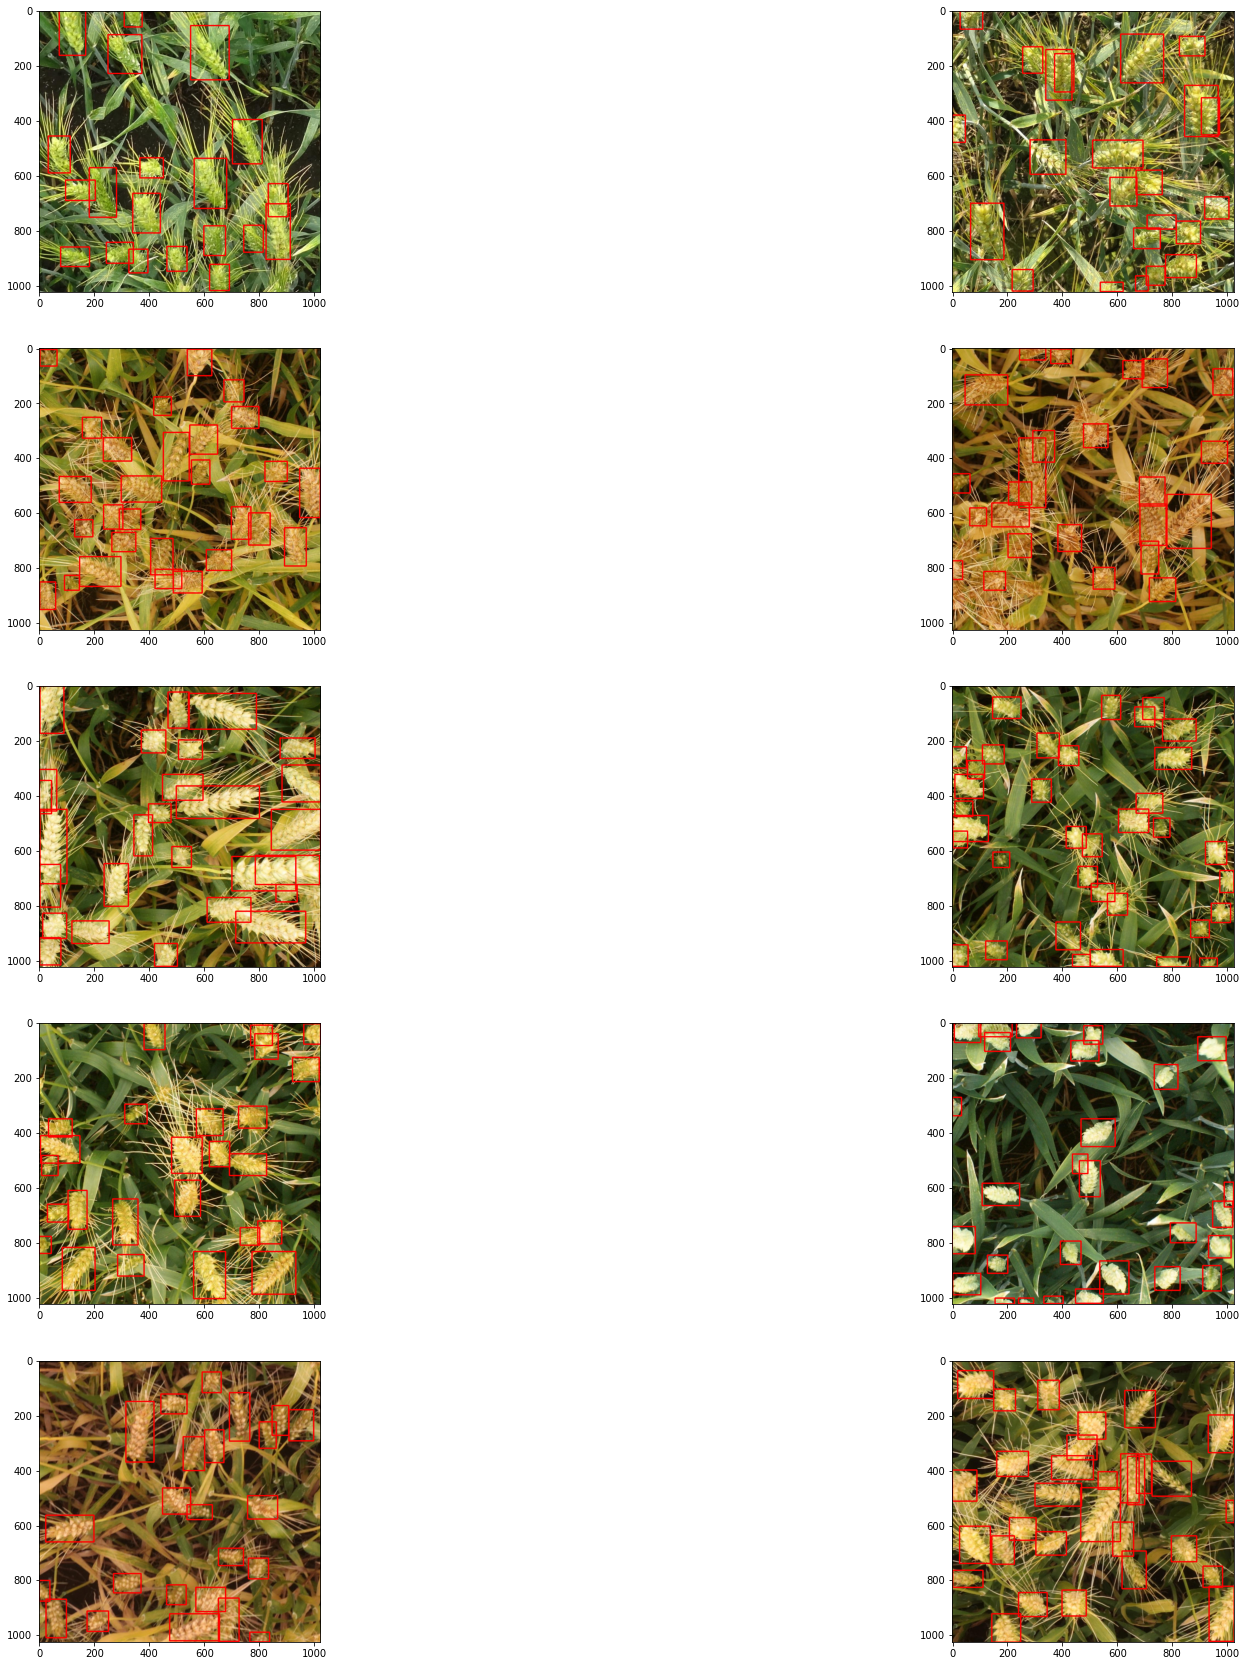

In [153]:
fig